# LOAD AND PREPARE DATA

In [1]:
!rm nlp_text.zip
!curl -o nlp_text.zip -L 'https://drive.google.com/uc?export=download&confirm=yes&id=1n6DF2zBa0N9IpXUGNCAXm6m8L26nb6PL'
!unzip -o nlp_text.zip

rm: cannot remove 'nlp_text.zip': No such file or directory
  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
  0     0    0     0    0     0      0      0 --:--:--  0:00:01 --:--:--     0
100 4180k  100 4180k    0     0  2022k      0  0:00:02  0:00:02 --:--:-- 90.7M
Archive:  nlp_text.zip
  inflating: sample_submission.csv   
  inflating: test.csv                
  inflating: train.csv               


In [2]:
# libraries

import numpy as np
import pandas as pd
from plotly.offline import iplot
import matplotlib.pyplot as plt
import seaborn as sns
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Embedding, LSTM, SpatialDropout1D
from sklearn.model_selection import train_test_split
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.layers import Dropout
import re
import nltk
from nltk.corpus import stopwords
from nltk import word_tokenize
nltk.download('stopwords')
STOPWORDS = set(stopwords.words('english'))


[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


In [3]:
train_data = pd.read_csv('train.csv')
test_data = pd.read_csv('test.csv')

In [4]:
train_data.shape

(41159, 3)

In [5]:
test_data.shape

(3798, 2)

In [6]:
train_data.head()

,Unnamed: 0,Text,Sentiment
0,0,@MeNyrbie @Phil_Gahan @Chrisitv https://t.co/i...,Neutral
1,1,advice Talk to your neighbours family to excha...,Positive
2,2,Coronavirus Australia: Woolworths to give elde...,Positive
3,3,My food stock is not the only one which is emp...,Positive
4,4,"Me, ready to go at supermarket during the #COV...",Extremely Negative


In [7]:
test_data.head()

,id,Text
0,787bc85b-20d4-46d8-84a0-562a2527f684,TRENDING: New Yorkers encounter empty supermar...
1,17e934cd-ba94-4d4f-9ac0-ead202abe241,When I couldn't find hand sanitizer at Fred Me...
2,5914534b-2b0f-4de8-bb8a-e25587697e0d,Find out how you can protect yourself and love...
3,cdf06cfe-29ae-48ee-ac6d-be448103ba45,#Panic buying hits #NewYork City as anxious sh...
4,aff63979-0256-4fb9-a2d9-86a3d3ca5470,#toiletpaper #dunnypaper #coronavirus #coronav...


In [8]:
train_data.isnull().sum()

Unnamed: 0    1
Text          1
Sentiment     4
dtype: int64

In [9]:
train_data = train_data.dropna()

In [10]:
test_data.isnull().sum()

id      0
Text    0
dtype: int64

In [11]:
# labels overview
train_data['Sentiment'].value_counts()

Positive              11422
Negative               9917
Neutral                7711
Extremely Positive     6624
Extremely Negative     5481
Name: Sentiment, dtype: int64

Как мы видим у нас несбалансированный датасет, поэтому мы применим технику для создания сбалансированного датасета

In [12]:
from pandas.io.stata import excessive_string_length_error
#I do aspire here to have balanced classes
num_of_categories = 5481
shuffled = train_data.reindex(np.random.permutation(train_data.index))

pos = shuffled[shuffled['Sentiment'] == 'Positive'][:num_of_categories]
neg = shuffled[shuffled['Sentiment'] == 'Negative'][:num_of_categories]
neut = shuffled[shuffled['Sentiment'] == 'Neutral'][:num_of_categories]
ext_pos = shuffled[shuffled['Sentiment'] == 'Extremely Positive'][:num_of_categories]
ext_neg = shuffled[shuffled['Sentiment'] == 'Extremely Negative'][:num_of_categories]
concated = pd.concat([pos, neg, neut, ext_pos, ext_neg], ignore_index = True)
#Shuffle the dataset
data = concated.reindex(np.random.permutation(concated.index))


In [13]:
def example_complain(index):
    example = data[data.index == index][['Text', 'Sentiment']].values[0]
    if len(example) > 0:
        print(example[0])
        print()
        print('Category:', example[1])

In [14]:
example_complain(10)

Since the mandated #covid19 closures across the US, #NielsenCGA have been monitoring the $ impact + #consumer behavior and perceptions since the outbreak. Here's the latest velocity analysis, w/e April 4. Download the latest free report and #insight here: https://t.co/gD9OlAGMsm https://t.co/SQC9lnSD4T

Category: Positive


In [15]:
data = data.reset_index(drop = True)
REPLACE_BY_SPACE_RE = re.compile('[/(){}\|@,;]')
BAD_SYMBOLS_RE = re.compile('[^0-9a-z #+_]')
STOPWORDS = set(stopwords.words('english'))

def clean_text(text):
    """
        text: a string

        return: modified initial string
    """
    text = text.lower() # lowercase text
    text = REPLACE_BY_SPACE_RE.sub(' ', text) # replace REPLACE_BY_SPACE_RE symbols by space in text. substitute the matched string in REPLACE_BY_SPACE_RE with space.
    text = BAD_SYMBOLS_RE.sub('', text) # remove symbols which are in BAD_SYMBOLS_RE from text. substitute the matched string in BAD_SYMBOLS_RE with nothing.
    text = text.replace('x', '')
#    text = re.sub(r'\W+', '', text)
    text = ' '.join(word for word in text.split() if word not in STOPWORDS) # remove stopwors from text
    return text
data['Text'] = data['Text'].apply(clean_text)

In [16]:
example_complain(10)

rjm8675309 cpho_canada china people must use similar app scan qr code taking public transit shopping mall supermarket entering office building traceable found covid 19 cases

Category: Neutral


In [17]:
# The maximum number of words to be used. (most frequent)
MAX_NB_WORDS = 50000
# Max number of words in each complaint.
MAX_SEQUENCE_LENGTH = 250
# This is fixed.
EMBEDDING_DIM = 100

tokenizer = Tokenizer(num_words=MAX_NB_WORDS, filters='!"#$%&()*+,-./:;<=>?@[\]^_`{|}~', lower=True)
tokenizer.fit_on_texts(data['Text'].values)
word_index = tokenizer.word_index
print('Found %s unique tokens.' % len(word_index))


Found 66384 unique tokens.


In [18]:
X = tokenizer.texts_to_sequences(data['Text'].values)
X = pad_sequences(X, maxlen=MAX_SEQUENCE_LENGTH)
print('Shape of data tensor:', X.shape)

Shape of data tensor: (27405, 250)


In [19]:
Y = pd.get_dummies(data['Sentiment']).values
print('Shape of label tensor:', Y.shape)

Shape of label tensor: (27405, 5)


In [20]:
X_train, X_val, Y_train, Y_val = train_test_split(X, Y, test_size = 0.10, random_state = 42)
print(X_train.shape,Y_train.shape)
print(X_val.shape,Y_val.shape)

(24664, 250) (24664, 5)
(2741, 250) (2741, 5)


# СОЗДАНИЕ МОДЕЛИ

In [21]:
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.compat.v1.keras.layers import CuDNNGRU

VOCAB_SIZE = len(tokenizer.word_index) + 1
# We've added 1 because of padding

# Each world will be 100D vector.
VECTOR_SIZE = 100

def build_model(MAX_LEN, embedding_weights=None):
    model = keras.Sequential()
    if embedding_weights is not None:
        model.add(layers.Embedding(input_dim=VOCAB_SIZE,
                                   output_dim=VECTOR_SIZE,
                                   input_length=MAX_LEN,
                                   weights=[embedding_weights],
                                   trainable=True
                                   ))
    else:
        model.add(layers.Embedding(input_dim=VOCAB_SIZE,
                                   output_dim=VECTOR_SIZE,
                                   input_length=MAX_LEN
                                   ))

    model.add(CuDNNGRU(512, return_sequences=True))
    model.add(CuDNNGRU(1024, return_sequences=True))
    model.add(CuDNNGRU(1024, return_sequences=False))
    model.add(layers.Dense(5, activation="softmax"))

    model.compile(optimizer="Adam", loss='categorical_crossentropy', metrics=["accuracy"])
    return model

In [22]:
model = build_model(MAX_SEQUENCE_LENGTH)
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 250, 100)          6638500   
                                                                 
 cu_dnngru (CuDNNGRU)        (None, 250, 512)          943104    
                                                                 
 cu_dnngru_1 (CuDNNGRU)      (None, 250, 1024)         4724736   
                                                                 
 cu_dnngru_2 (CuDNNGRU)      (None, 1024)              6297600   
                                                                 
 dense (Dense)               (None, 5)                 5125      
                                                                 
Total params: 18609065 (70.99 MB)
Trainable params: 18609065 (70.99 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [27]:
!rm glove.zip
!curl -o glove.zip -L 'https://drive.google.com/uc?export=download&confirm=yes&id=1EHBDcDlqN-0ZTjmLtTMnyvZH0ls_8IW3'
!unzip -o glove.zip

rm: cannot remove 'glove.zip': No such file or directory
  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
  0     0    0     0    0     0      0      0 --:--:-- --:--:-- --:--:--     0
100  131M  100  131M    0     0  36.7M      0  0:00:03  0:00:03 --:--:-- 53.1M
Archive:  glove.zip
  inflating: glove.6B.100d.txt       


In [28]:
word2vec = {} # Trained glove model
with open("glove.6B.100d.txt",encoding="UTF-8") as f:
    for line in f:
        values = line.split()
        word = values[0]
        vec = np.asarray(values[1:],dtype="float32")
        word2vec[word] = vec

In [29]:
import numpy as np

# initializing as uniform
embedding_matrix = np.random.uniform(-1, 1, (VOCAB_SIZE, 100))

for word,i in tokenizer.word_index.items():
    if i < VOCAB_SIZE:
        embedding_vector = word2vec.get(word)
        if embedding_vector is not None:
            embedding_matrix[i] = embedding_vector

In [31]:
model = build_model(MAX_SEQUENCE_LENGTH,embedding_matrix)

In [32]:
epochs = 10
batch_size = 64

model.fit(X_train, Y_train, epochs=epochs, batch_size=batch_size,validation_split=0.1,callbacks=[EarlyStopping(monitor='val_loss')])

Epoch 1/10
347/347 [==============================] - 142s 401ms/step - loss: 1.1747 - accuracy: 0.5042 - val_loss: 0.9059 - val_accuracy: 0.6409
Epoch 2/10
347/347 [==============================] - 133s 383ms/step - loss: 0.7650 - accuracy: 0.7110 - val_loss: 0.8217 - val_accuracy: 0.6867
Epoch 3/10
347/347 [==============================] - 132s 379ms/step - loss: 0.5897 - accuracy: 0.7891 - val_loss: 0.7846 - val_accuracy: 0.7223
Epoch 4/10
347/347 [==============================] - 131s 377ms/step - loss: 0.4574 - accuracy: 0.8425 - val_loss: 0.8139 - val_accuracy: 0.7207


86/86 [==============================] - 7s 77ms/step
Accuracy score is 67.6% 


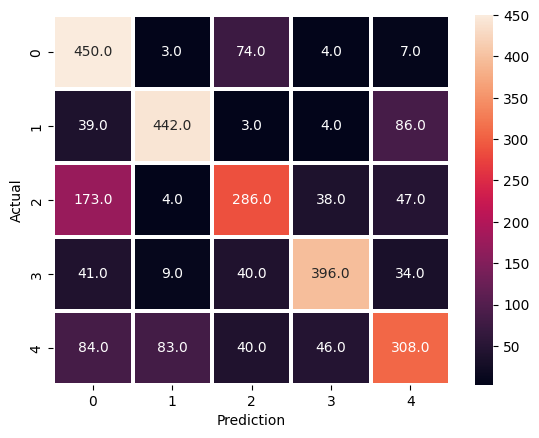

In [36]:
from sklearn.metrics import confusion_matrix, accuracy_score
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

# Change this threshold depending on your problem domain
threshold = 0.5

# Assuming your model outputs continuous multi-output probabilities
y_pred_proba = model.predict(X_val)

# Convert probabilities to binary class membership (0/1)
y_pred = (y_pred_proba > threshold).astype(int)

# Calculate the accuracy score and confusion matrix
accuracy_sc = round(accuracy_score(y_pred=y_pred, y_true=Y_val) * 100, 2)
conf_matrix = confusion_matrix(y_pred=y_pred.argmax(axis=1), y_true=Y_val.argmax(axis=1))

print("Accuracy score is {}% ".format(accuracy_sc))

plt.subplots()
sns.heatmap(conf_matrix, annot=True, linewidths=1.5, fmt=".1f")
plt.xlabel("Prediction")
plt.ylabel("Actual")
plt.show()

# ПРЕДСКАЗАНИЯ И ВЫГРУЗКА РЕШЕНИЯ

Create Submission

In [38]:
sub = pd.read_csv('sample_submission.csv')
sub.head()

,id,Sentiment
0,787bc85b-20d4-46d8-84a0-562a2527f684,Neutral
1,17e934cd-ba94-4d4f-9ac0-ead202abe241,Neutral
2,5914534b-2b0f-4de8-bb8a-e25587697e0d,Neutral
3,cdf06cfe-29ae-48ee-ac6d-be448103ba45,Neutral
4,aff63979-0256-4fb9-a2d9-86a3d3ca5470,Neutral


In [39]:
text = test_data['Text'][0]
text

'TRENDING: New Yorkers encounter empty supermarket shelves (pictured, Wegmans in Brooklyn), sold-out online grocers (FoodKick, MaxDelivery) as #coronavirus-fearing shoppers stock up https://t.co/Gr76pcrLWh https://t.co/ivMKMsqdT1'

In [73]:
tokenizer = Tokenizer(num_words=MAX_NB_WORDS, filters='!"#$%&()*+,-./:;<=>?@[\]^_`{|}~', lower=True)
tokenizer.fit_on_texts(test_data['Text'].values)
labels = ['Positive', 'Negative', 'Neutral', 'Extremely Positive', 'Extremely Negative']


def get_prediction_for_test_data(text):
    text = clean_text(text)
    seq = tokenizer.texts_to_sequences([text])  # Обратите внимание на квадратные скобки
    padded = pad_sequences(seq, maxlen=MAX_SEQUENCE_LENGTH)
    predictions = model.predict(padded)
    pred_labels = np.argmax(predictions, axis=1)

    return labels[pred_labels[0]]

In [75]:
get_prediction_for_test_data(test_data['Text'][465])

1/1 [==============================] - 0s 33ms/step


'Extremely Positive'

In [76]:
test_data['Sentiment'] = test_data['Text'].apply(lambda x : get_prediction_for_test_data(x))

1/1 [==============================] - 0s 39ms/step


In [77]:
test_data['Sentiment'].value_counts()

Extremely Negative    1085
Neutral                982
Extremely Positive     604
Negative               576
Positive               551
Name: Sentiment, dtype: int64

In [78]:
test_data.head()

,id,Text,Sentiment
0,787bc85b-20d4-46d8-84a0-562a2527f684,TRENDING: New Yorkers encounter empty supermar...,Negative
1,17e934cd-ba94-4d4f-9ac0-ead202abe241,When I couldn't find hand sanitizer at Fred Me...,Positive
2,5914534b-2b0f-4de8-bb8a-e25587697e0d,Find out how you can protect yourself and love...,Neutral
3,cdf06cfe-29ae-48ee-ac6d-be448103ba45,#Panic buying hits #NewYork City as anxious sh...,Neutral
4,aff63979-0256-4fb9-a2d9-86a3d3ca5470,#toiletpaper #dunnypaper #coronavirus #coronav...,Extremely Negative


In [82]:
test_data = test_data.drop('Text',axis='columns')
test_data.head()

,id,Sentiment
0,787bc85b-20d4-46d8-84a0-562a2527f684,Negative
1,17e934cd-ba94-4d4f-9ac0-ead202abe241,Positive
2,5914534b-2b0f-4de8-bb8a-e25587697e0d,Neutral
3,cdf06cfe-29ae-48ee-ac6d-be448103ba45,Neutral
4,aff63979-0256-4fb9-a2d9-86a3d3ca5470,Extremely Negative


In [83]:
test_data.to_csv('submission.csv', index = False)